In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import psycopg2
from sqlalchemy import create_engine 

import re
from tqdm import tqdm
from datetime import datetime, timedelta

In [2]:
dbname = '...'
user = '...'
password = '...'
host = '...'
port = '...'

conn_string = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

In [3]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

df = pd.read_sql_query('SELECT * FROM raw_data', conn)
conn.close()

## Main

In [4]:
df.describe(include='all')

website                               section  \
count       39776                                 39776   
unique          4                                   201   
top     Интерфакс  Новости компаний и новости по акциям   
freq        14686                                 12472   

                                                url  \
count                                         39776   
unique                                        39766   
top     https://ria.ru/20230531/gaz-1875325632.html   
freq                                              2   

                                                   header      body  \
count                                               39776     39775   
unique                                              39172     39755   
top     "Газпром" подает газ через Украину на ГИС "Суд...  Источник   
freq                                                   34         3   

                          date   tags  
count                    39776  39627  
unique                   38616  27762  
top     29 августа 2023, 13:55     []  
freq                         5   2671

> __Выводы:__  
> 1. Можно заметить, что у нас нет пропусков в данных  
> 2. Можно заметить, что у нас есть url'ы, которые представлены более одного раза, что намекает нам на наличие дубликатов, от которых ужно будет избавиться  
> 3. Можно заметить, что у нас есть новости с похожими заголовками, как следствие, нужно будет понять, являются ли такие новости дубликатами и определиться, что с ними делать  
> 4. Можно заметить, что у нас есть новости с полностью повторяющимися текстами небольшой длины, что, скорее всего, свидетельствует о необходимости избавиться от подобных 'пустых' новостей 

## URL

In [5]:
df[['url']].groupby('url').value_counts().sort_values().tail(11)

url
https://smart-lab.ru/blog/896323.php                  1
https://ria.ru/20230531/mongoliya-1875328673.html     2
https://ria.ru/20230531/gaz-1875325632.html           2
https://ria.ru/20230531/vstrecha-1875349749.html      2
https://ria.ru/20230531/volkswagen-1875349174.html    2
https://ria.ru/20230531/gaz-1875314656.html           2
https://ria.ru/20230531/gaz-1875308876.html           2
https://ria.ru/20230531/peregovory-1875357995.html    2
https://ria.ru/20230531/rosneft-1875372066.html       2
https://ria.ru/20230531/gazprom-1875372984.html       2
https://ria.ru/20230531/nalog-1875319473.html         2
Name: count, dtype: int64

In [6]:
'''
Не указываем, по какой колонке убирать дубликаты, чтобы убедиться, 
что эти 10 новостей точные дубликаты уже представленных новостей
'''
df_new = df.drop_duplicates()

In [7]:
df_new.describe(include='all')

website                               section  \
count       39766                                 39766   
unique          4                                   201   
top     Интерфакс  Новости компаний и новости по акциям   
freq        14686                                 12472   

                                          url  \
count                                   39766   
unique                                  39766   
top     https://www.interfax.ru/russia/879448   
freq                                        1   

                                                   header      body  \
count                                               39766     39765   
unique                                              39172     39755   
top     "Газпром" подает газ через Украину на ГИС "Суд...  Источник   
freq                                                   34         3   

                     date   tags  
count               39766  39617  
unique              38616  27762  
top     06.10.2023, 01:04     []  
freq                    5   2671

> __Выводы:__ Теперь все url'ы у нас уникальны (к тому же, мы поняли, что эти 10 удаленных новостей были полными дубликатами уже представленных новостей)

## Body

#### 1. Почистим тексты от неинформативных частей

1.1 В первую очередь, избавимся от внешних ссылок в текстах (в тестовом формате)

In [8]:
patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
]

In [9]:
links = []
ids = []

for i in tqdm(range(df_new.shape[0])):
    if df_new.iloc[i,:].body is not None:
        for pattern in patterns:
            lst_help = re.findall(pattern, df_new.iloc[i,:].body)
            if lst_help:
                links.extend(lst_help)
                ids.append(i)

# print(len(links))
# print(links)

  0%|          | 0/39766 [00:00<?, ?it/s]100%|██████████| 39766/39766 [00:28<00:00, 1375.97it/s]


Теперь же, после того, как мы убедились, что наш regex pattern правильно отыскивает внешние ссылки в текстах (по крайней мере, значительную их часть), можно от них избавиться в самих текстах

In [10]:
def remove_links(text):
    patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
    ]
    
    if text is not None:
        for pattern in patterns:
            text = re.sub(pattern, ' ', text)
    
    return text

vectorized_remove_links = np.vectorize(remove_links)

In [11]:
df_new = df_new.copy()
df_new['body'] = vectorized_remove_links(df_new.body)

1.2 Теперь пройдемся по отдельным порталам, в которых повторяются одни и те же куски текста, и избавимся от них (в нашем случае это РИА и Интерфакс)

In [12]:
def sub_ria(text):
    pattern = r'^.*(?:—|-|–) РИА Новости(?:.|,)'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_ria = np.vectorize(sub_ria)

df_new['body'] = vectorized_sub_ria(df_new.body)

In [13]:
def sub_interfax(text):
    pattern = r'^.*INTERFAX.RU'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_interfax = np.vectorize(sub_interfax)

df_new['body'] = vectorized_sub_interfax(df_new.body)

#### 2. После того, как мы избавились от неинформативных и ненужных частей в текстах новостей, можно посмотреть на распределение длин текстов и, как следствие, избавиться от новостей с очень короткими (почти не содержащими информации) текстами и от новостей с полностью дублирующимися текстами

2.1 Сначала удалим короткие новости среди всех порталов

In [14]:
df_new.loc[:, 'body_length'] = df_new['body'].apply(len)

In [15]:
quantile_lst = []
for i in [round(0.01 + 1/100*i, 2) for i in range(10)]:
    length = df_new[["body_length"]].quantile(i)[0]
    quantile_lst.append(length)
    print(f'Квантиль {i}: {int(length)}')
    
quantile_lst = [int(i) for i in quantile_lst]

Квантиль 0.01: 60
Квантиль 0.02: 98
Квантиль 0.03: 123
Квантиль 0.04: 157
Квантиль 0.05: 200
Квантиль 0.06: 241
Квантиль 0.07: 276
Квантиль 0.08: 309
Квантиль 0.09: 337
Квантиль 0.1: 362


C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\1831254341.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = df_new[["body_length"]].quantile(i)[0]
C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\1831254341.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = df_new[["body_length"]].quantile(i)[0]
C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\1831254341.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  l

In [16]:
for i, quantile_len in enumerate(quantile_lst):
    print(f'Квантиль {(i+1)/100} c длиной: {quantile_len}')
    print(df_new[df_new['body_length']>quantile_len].sort_values(by='body_length').iloc[0,:].body)
    print('-------------------------------------------------------------------------------------')

Квантиль 0.01 c длиной: 60
«Дагестанская энергосбытовая компания» Отчет МСФО

Источник: 
-------------------------------------------------------------------------------------
Квантиль 0.02 c длиной: 98
25 августа 2023 года - НОВАТЭК - СД решит по дивидендам

Самые быстрые новости у нас!  

Источник: 
-------------------------------------------------------------------------------------
Квантиль 0.03 c длиной: 123
01.06.2023 - «Газпром газораспределение Ростов-на-Дону» - СД решит по дивидендам

Самые быстрые новости у нас!  

Источник: 
-------------------------------------------------------------------------------------
Квантиль 0.04 c длиной: 157
ИСКЧ — решение акционеров: выплатить дивиденды за 2022-й год в размере 1 руб на 1 обыкновенную акцию

hsci.ru/news/iskch-prinyal-reshenie-o-vyplate-dividendov
-------------------------------------------------------------------------------------
Квантиль 0.05 c длиной: 200
Процедуру банкротства оператора газопровода Nord Stream 2 AG продлили ещ

Можно заметить, что начиная с квантили 0.05, новости идут уже достаточно информативными, следовательно, все новости с текстами длины менее 200 мы удалим

In [17]:
df_new.drop(df_new[df_new['body_length'] < 200].index, inplace=True)

In [18]:
df_new[['body']].describe()

body
count                                               37785
unique                                              37781
top     Проект увеличения мощности золотоизвлекательно...
freq                                                    2

2.2 Видим, что у нас все еще остались новости с дублирующимися текстами, необходимо избавиться от дубликатов

In [19]:
df_new[['body']].groupby('body').value_counts().sort_values().tail(5)

body
  - Суды приостановили эксплуатацию трех объектов АО "Саханефтегазсбыт" (СНГС) по требованию Ленского управления Ростехнадзора, говорится на сайте надзорного ведомства.\n"Якутский городской суд и Ленский районный суд приостановили деятельность на три месяца на нефтебазах в поселке Усть-Куйга и Олекминск. Эксплуатация нефтебазы в Ленске приостановлена на 30 суток", - говорится в сообщении.\nПо информации управления Ростехнадзора, при проверке объектов компании было выявлено 115 нарушений правил безопасной эксплуатации, в связи с чем наложены временные запреты деятельности на четыре нефтебазы СНГС, однако временный запрет деятельности нефтебазы Якутска горсуд заменил на штраф в размере 200 тыс. рублей.\nВ ходе проверки было установлено, в частности, что объекты не оснащены автоматизированными системами управления, не предусмотрена система противоаварийной автоматической защиты, главный инженер и инженерно-технический персонал не аттестованы в области промышленной безопасности. Кроме

In [20]:
lst_suplicated_body = [i for i in df_new[['body']].groupby('body').value_counts().sort_values().tail(4).keys()]

In [21]:
df_new[df_new['body'].isin(lst_suplicated_body)]

website                                     section  \
2341   Интерфакс                                   ЭКОНОМИКА   
2438   Интерфакс                                   ЭКОНОМИКА   
27056  Smart_Lab        Новости компаний и новости по акциям   
27074  Smart_Lab        Новости компаний и новости по акциям   
30098        РИА                                   Экономика   
30105        РИА                                   Экономика   
34857        РИА  Ситуация с курсами валют и ценами на нефть   
34858        РИА  Ситуация с курсами валют и ценами на нефть   

                                                    url  \
2341            https://www.interfax.ru/business/886788   
2438            https://www.interfax.ru/business/886978   
27056              https://smart-lab.ru/blog/950006.php   
27074              https://smart-lab.ru/blog/949931.php   
30098  https://ria.ru/20230404/avtoprom-1862860685.html   
30105      https://ria.ru/20230404/avto-1862861778.html   
34857      https://ria.ru/20230814/rubl-1890027603.html   
34858      https://ria.ru/20230814/kurs-1890022534.html   

                                                  header  \
2341   Путин разрешил "Компании ВК" приобрести 100% д...   
2438   Путин разрешил российскому юрлицу VK выкупить ...   
27056  Селигдар намерен нарастить мощность фабрики на...   
27074  Фабрика «Селигдара» на производственном компле...   
30098        Путин рассказал о мерах поддержки автопрома   
30105  Путин пообещал кратное увеличение выпуска авто...   
34857  Рубль перешел к росту против доллара, евро и юаня   
34858             Доллар на Мосбирже упал ниже 99 рублей   

                                                    body  \
2341     - Президент РФ Владимир Путин разрешил приоб...   
2438     - Президент РФ Владимир Путин разрешил приоб...   
27056  Проект увеличения мощности золотоизвлекательно...   
27074  Проект увеличения мощности золотоизвлекательно...   
30098    Президент России Владимир Путин заявил, что ...   
30105    Президент России Владимир Путин заявил, что ...   
34857    Рубль перешел к укреплению на сообщении о вн...   
34858    Рубль перешел к укреплению на сообщении о вн...   

                                                  date  \
2341                            22:38, 17 февраля 2023   
2438                            13:26, 20 февраля 2023   
27056                           13 октября 2023, 12:28   
27074                           13 октября 2023, 10:25   
30098  12:09 04.04.2023\n(обновлено: 12:36 04.04.2023)   
30105  12:12 04.04.2023\n(обновлено: 12:29 04.04.2023)   
34857  17:38 14.08.2023\n(обновлено: 17:42 14.08.2023)   
34858  17:17 14.08.2023\n(обновлено: 17:42 14.08.2023)   

                                                    tags  body_length  
2341                   ['Компания ВК', 'Деньги.Мэйл.Ру']         1348  
2438          ['VK', 'Деньги.Мэйл.ру', 'Владимир Путин']         1348  
27056                       ['Селигдар', 'полюс золото']         1227  
27074  ['Селигдар', 'фабрика Рябиновая', 'золотодобыч...         1227  
30098  ['Владимир Путин', 'Экономика', 'Авто', 'Россия']          418  
30105  ['Россия', 'Экономика', 'Авто', 'Владимир Путин']          418  
34857  ['Ситуация с курсами валют и ценами на нефть',...          638  
34858  ['Ситуация с курсами валют и ценами на нефть',...          638

Оставим более ранние новости (больше подходит под наши дальнейшие задачи)

In [22]:
df_new.drop(df_new[df_new.index.isin([2438, 27056, 30105, 34857])].index, inplace=True)

In [23]:
df_new[['body']].describe()

body
count                                               37781
unique                                              37781
top       - Банк России с начала 2023 года отменяет ча...
freq                                                    1

#### 3. После проведенной чистки можно еще взглянуть на распределение длин текстов относительно разных порталов

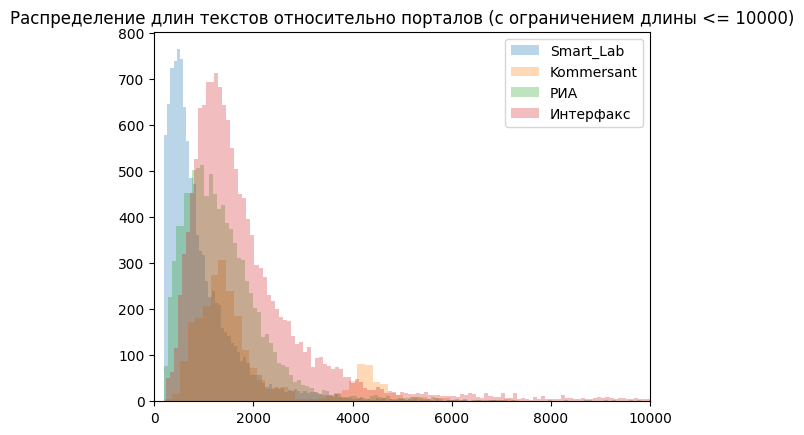

In [24]:
for portal in ['Smart_Lab', 'Kommersant', 'РИА', 'Интерфакс']:
    plt.hist(df_new[df_new['website']==portal].body_length, bins=400, alpha=0.3, label=portal)

plt.xlim(0, 10000)

plt.title('Распределение длин текстов относительно порталов (с ограничением длины <= 10000)')
plt.legend()
plt.show()

> __Выводы:__  
> 1. Мы почистили тексты от неинформативных и ненужных частей, которые могли бы навредить качеству наших последующих моделей
> 2. После чистики текстов новостей мы избавились от практически неинформативных и дублирующихся новостей 
> 3. Можно заметить, что у нас распределение длин текстов новостей определеятся порталом, из которго новость была взята, на данный момент это не дает нам какой-то конкретной информации (кроме того, что у нас достаточно разношерстный корпусов текстов), но мы будем держать это в уме при последующем обучении моделей 

# Section

> __Рассуждения:__ Изначально была идея избавиться от новостей, которые не подходят под нашу тему на основе неподходящих секций, но, по итогу, решили, что неподходящие новости мы отсеем на этапе извлечения сущностей, так как новость в таком случае будет считаться неподходящей, если не содержит в себе нужную(ые) нам сущность(и).  
>
> Как следствие, на данный момент никаких преобразований на основе информации о секции, из которой была взята новость, решили не делать

## Header

In [25]:
df_new[['header']].groupby('header').value_counts().sort_values().tail(354)

header
Для дальнейшего значимого восстановления акций Сбера нужно снижение геополитических рисков - Финам     1
Нефть Brent подешевела до $75,5 за баррель                                                             2
VK приобретает 51% в коммуникационном агентстве Didenok Team                                           2
В Кремле рассказали о ситуации с зерновой сделкой                                                      2
Инфляция во Франции в июне замедлилась до 5,3%                                                         2
                                                                                                      ..
ТОП российских акций средней и малой капитализации: обновление состава - СберИнвестиции                6
Рубль утром стабилен относительно доллара и юаня                                                       6
Цена бензина Аи-95 на российской бирже обновила рекорд                                                 9
В России замедлилась недельная инфляция         

> __Выводы:__ Как можно заметить, много новостей имеют повторяющиеся заголовки, но эти новости не являются дубликатами, так как дата их публикации и текст отличаются, как следствие, это просто разные новости, написанные по схожим шаблонам под одинаковыми заголовками. Избавляться от подобных новостей мы не будем

## Date

Обработка дат, вычисление количества новостей на дату

### Интерфакс

In [26]:
df_interfax = df_new[df_new['website']=='Интерфакс']
df_interfax = df_interfax.reset_index()
df_interfax = df_interfax.drop('index', axis=1)

In [27]:
months = {"января": "1", "февраля": "2", "марта": "3", "апреля": "4", "мая": "5", "июня": "6", "июля":"7", "августа":"8", "сентября":"9", "октября":"10"}
def monthconvert(date):
    for word, initial in months.items():
        date = date.replace(word.lower(), initial)
    return date

In [28]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%H:%M, %d %m %Y')
    return datetime_object

In [29]:
for i in range(len(df_interfax)):
    df_interfax['date'][i] = datechanger(df_interfax['date'][i])

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\755838020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interfax['date'][i] = datechanger(df_interfax['date'][i])
C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\755838020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interfax['date'][i] = datechanger(df_interfax['date'][i])
C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\755838020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [30]:
df_interfax['datetime'] = df_interfax['date']

In [31]:
dates = []
for i in range(len(df_interfax)):
    dates.append(datetime.date(df_interfax['datetime'][i]))
df_interfax['date'] = dates

In [32]:
weekend = pd.Series()
s = pd.date_range('2023-01-01', '2023-10-24', freq='D').to_series()
for i in s:
    if i.weekday() == 5 or i.weekday() == 6 or i in [datetime(2023, 1, 1), datetime(2023, 1, 2), datetime(2023, 1, 7), datetime(2023, 2, 23),
                                                                    datetime(2023, 3, 8), datetime(2023, 5, 1), datetime(2023, 5, 9),
                                                                    datetime(2023, 6, 12)]:
        weekend[i] = 1
    else:
        weekend[i] = 0

In [33]:
news_by_date = df_interfax.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

In [34]:
def plot_news(source:str):
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=news_by_date.index, y=weekend,
                             fill = 'tonexty', fillcolor = 'rgba(255, 0, 0, 0.4)',
                             line_shape = 'hv', line_color = 'rgba(0,0,0,0)',
                             showlegend = True, name='Weekends and holidays'
                            ),
                row = 1, col = 1, secondary_y=True)

    fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day'))

    fig.update_layout(
        title = 'News per day {}'.format(source),
        width=1200,
        height=450,
        xaxis=dict(
            rangeselector=dict(),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show('svg')

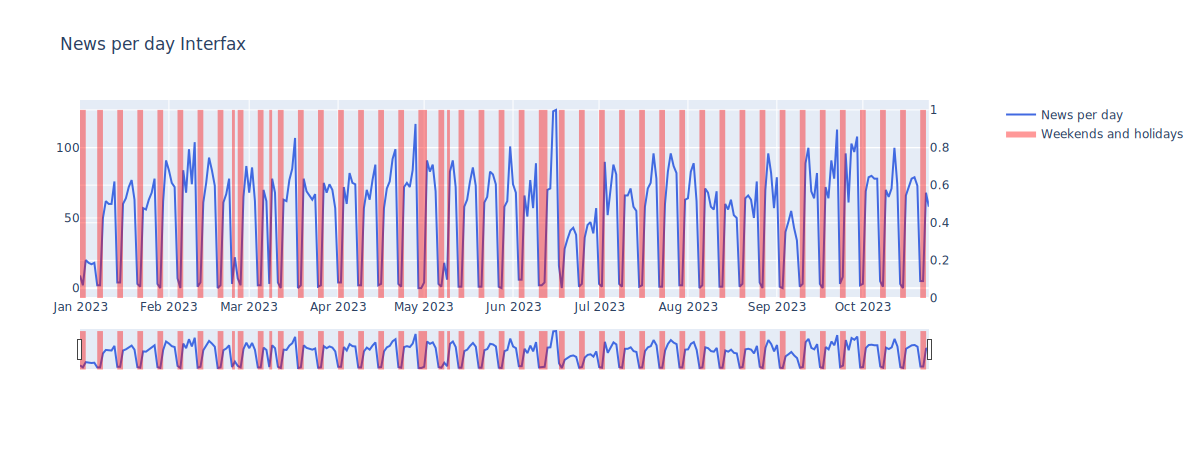

In [35]:
plot_news('Interfax')

> __Промежуточные выводы:__ Большая часть падений количества новостей совпадает с выходными и праздничными днями, в которые биржа не работала. Среднее количество новостей примерно равно 75. Есть небольшой провал в количестве новостей в конце июня.

### РИА

In [36]:
df_ria = df_new[df_new['website']=='РИА']
df_ria = df_ria.reset_index()
df_ria = df_ria.drop('index', axis=1)

In [37]:
def splitter(str):
    return str.split('\n')

In [38]:
dates_init = []
dates_upd = []
splited = df_ria.date.apply(splitter)
for i in splited:
    dates_init.append(i[0])
    try:
        dates_upd.append(i[1])
    except IndexError:
        dates_upd.append(None)

In [39]:
dates_upd = [i for i in dates_upd if i is not None]
dates_upd = [datetime.strptime(i[12:28], '%H:%M %d.%m.%Y') for i in dates_upd]

In [40]:
df_ria['datetime'] = np.zeros(len(df_ria))
for i in range(len(df_ria)):
    df_ria['datetime'][i] = datetime.strptime(dates_init[i], '%H:%M %d.%m.%Y')

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\566151837.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\566151837.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-01-04 16:36:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [41]:
dates = []
for i in range(len(df_ria)):
    dates.append(datetime.date(df_ria['datetime'][i]))
df_ria['date'] = dates

In [42]:
news_by_date = df_ria.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

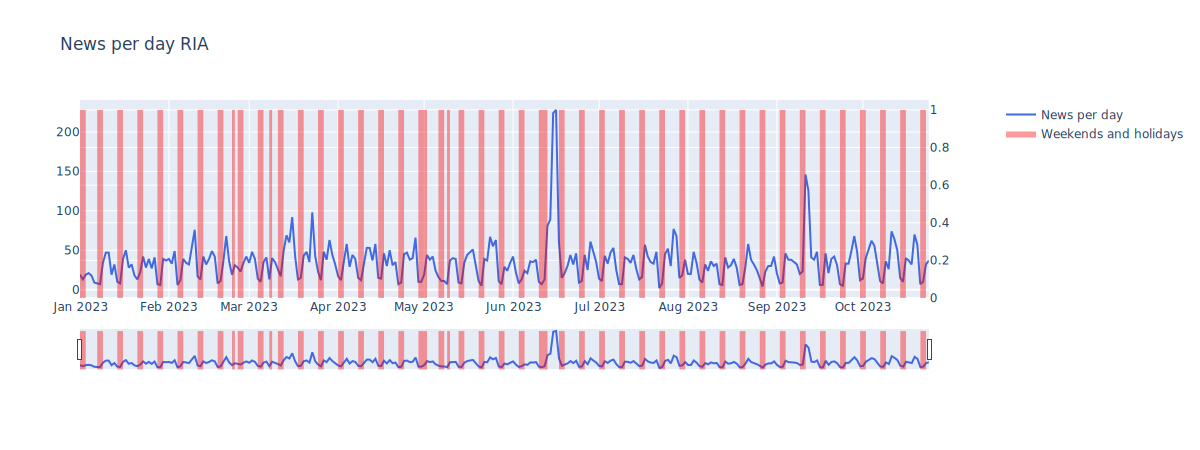

In [43]:
plot_news('RIA')

> __Промежуточные выводы:__ Большая часть падений количества новостей совпадает с выходными и праздничными днями, в которые биржа не работала. Среднее количество новостей примерно равно 50. Есть очень высокие пики в июне, когда проходил ПМЭФ, а также в сентябре, когда проходил ВЭФ.

### Смарт-лаб

In [44]:
df_smart_lab = df_new[df_new['website']=='Smart_Lab']
df_smart_lab = df_smart_lab.reset_index()
df_smart_lab = df_smart_lab.drop('index', axis=1)

In [45]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%d %m %Y, %H:%M')
    return datetime_object

In [46]:
df_smart_lab['datetime'] = np.zeros(len(df_smart_lab))
for i in range(len(df_smart_lab)):
    df_smart_lab['datetime'][i] = datechanger(df_smart_lab['date'][i])

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\3609216373.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\3609216373.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-07-13 17:51:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [47]:
dates = []
for i in range(len(df_smart_lab)):
    dates.append(datetime.date(df_smart_lab['datetime'][i]))
df_smart_lab['date'] = dates

In [48]:
news_by_date = df_smart_lab.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

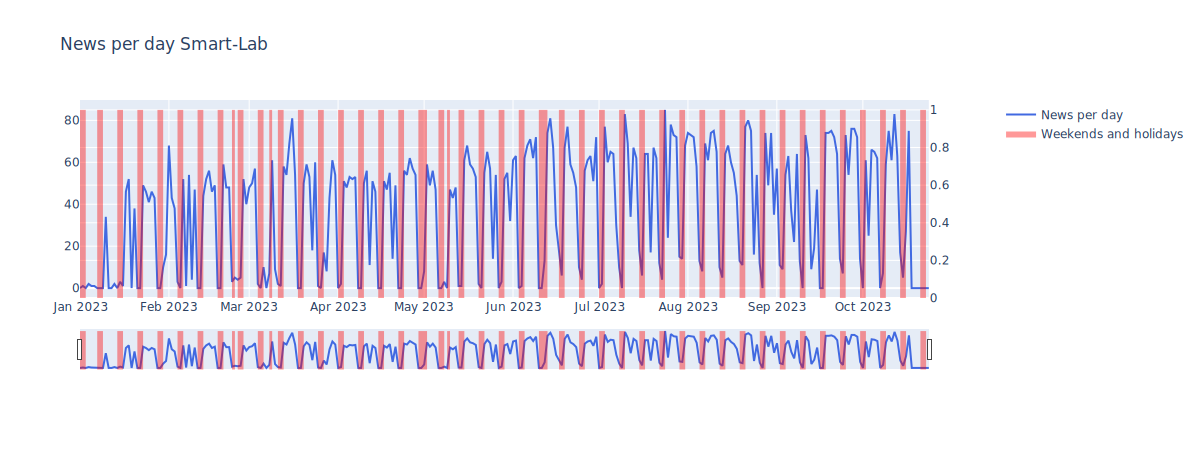

In [49]:
plot_news('Smart-Lab')

> __Промежуточные выводы:__ Большая часть падений количества новостей совпадает с выходными и праздничными днями, в которые биржа не работала. Среднее количество новостей примерно равно 70. Отклоняется от других источников тем, что есть много других провалов по количеству новостей. Возможная причина: характер самого портала, аггрегация новостей с лагами.

### Коммерсантъ

In [50]:
df_kommersant = df_new[df_new['website']=='Kommersant']
df_kommersant = df_kommersant.reset_index()
df_kommersant = df_kommersant.drop('index', axis=1)

In [51]:
df_kommersant['tags'] = df_kommersant['tags'].replace('[]', np.NaN)

In [52]:
df_kommersant['datetime'] = np.zeros(len(df_kommersant))
for i in range(len(df_kommersant)):
    df_kommersant['datetime'][i] = datetime.strptime(df_kommersant['date'][i], '%d.%m.%Y, %H:%M')

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\2041172035.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxod\AppData\Local\Temp\ipykernel_18316\2041172035.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-04-27 22:43:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [53]:
dates = []
for i in range(len(df_kommersant)):
    dates.append(datetime.date(df_kommersant['datetime'][i]))
df_kommersant['date'] = dates

In [54]:
news_by_date = df_kommersant.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

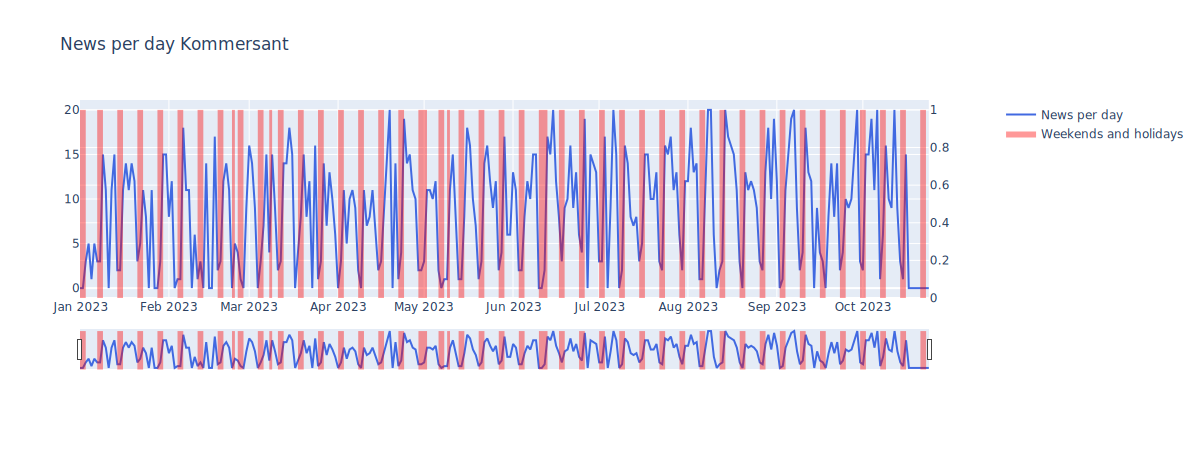

In [55]:
plot_news('Kommersant')

> __Промежуточные выводы:__ Большая часть падений количества новостей совпадает с выходными и праздничными днями, в которые биржа не работала. Среднее количество новостей примерно равно 12-13.

### Общий датасет

In [56]:
df_total = pd.concat(
    [df_interfax, df_ria, df_smart_lab, df_kommersant],
    axis=0,
    ignore_index=True
)

In [57]:
news_by_date = df_total.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

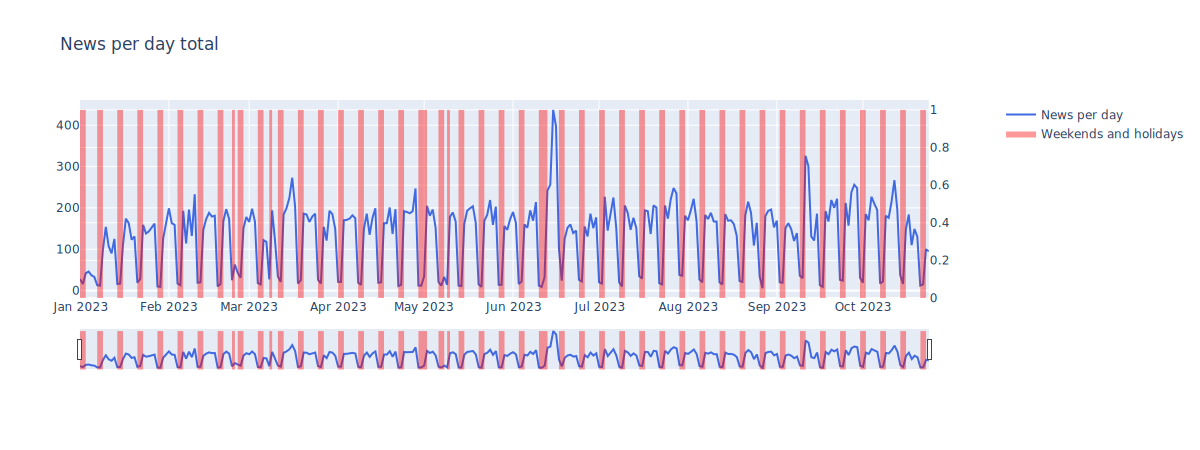

In [58]:
plot_news('total')

> __Промежуточные выводы:__ Общий график выглядит как смесь Интерфакса и РИА из-за количества новостей именно из этих изданий. На общей картине уменьшение количества новостей еще чаще совпадает с нерабочими для биржи днями.

In [59]:
ts_total = df_total.copy()

In [60]:
ts_total.index = ts_total['datetime']

    Оставим данные только для дат, которые доступны по всем изданиям.

    Исключим дни, в которые биржа не работала.

    Ограничимся новостями, влияние которых можно отследить, взяв новости только в промежутках с 9:30 утра до половины 12 вечером.

In [61]:
ts_total = ts_total[ts_total.index.weekday < 5].between_time('9:30', '23:30')
ts_total = ts_total[~(ts_total['date'].isin(pd.Series([datetime(2023, 1, 1), datetime(2023, 1, 2), datetime(2023, 1, 7), datetime(2023, 2, 23),
                                                                    datetime(2023, 3, 8), datetime(2023, 5, 1), datetime(2023, 5, 9),
                                                                    datetime(2023, 6, 12)]).dt.date.tolist()))]
ts_total = ts_total.sort_index().loc['2023-01-01' : '2023-10-17', :] 

In [62]:
news_by_date = ts_total.groupby('date').date.count()

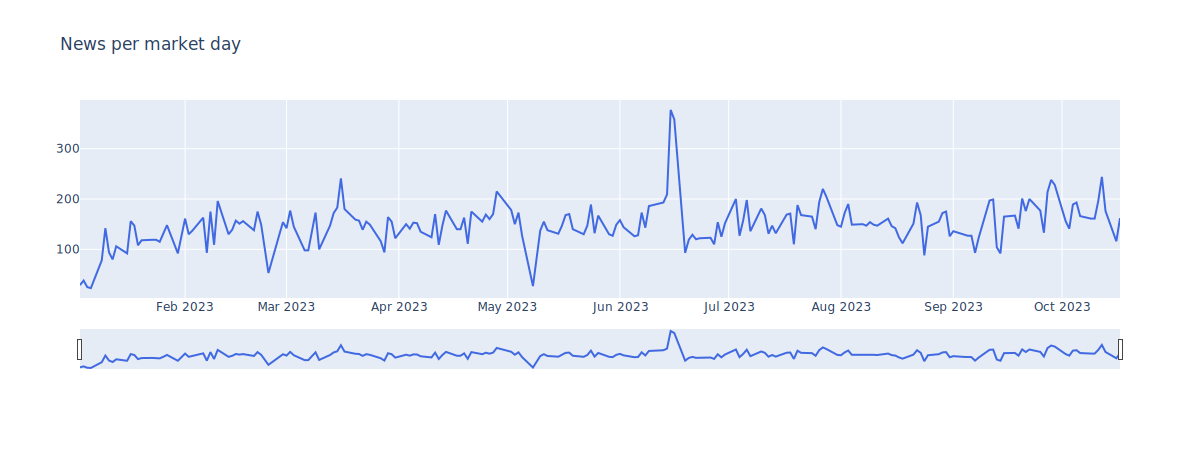

In [63]:
fig = go.Figure()
fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day', 
                   ))

fig.update_layout(
    title='News per market day',
    width=1200,
    height=450,
    xaxis=dict(
        rangeselector=dict(),
        rangeslider=dict(
            visible=True
        ),
        type="date"
        ))

fig.show('svg')

> __Выводы:__ 
> По временному ряду новостей видно, что количество новостей колеблется около среднего в примерно 160-170 новостей в день в дни, когда работает Московская биржа.
>
> Есть отдельные сильные провалы, связанные с выходными днями по общему календарю, однако биржа в этот день работала, поэтому мы не исключали эти даты. Это начало января, 24 февраля и 8 мая.
>
> Есть и очень насыщенный день 15 июня. Вероятно, это связано с проведением ПМЭФ.
>
> В целом, ряд выглядит относительно стационарным, сезонности и трендов после исключения выходных и праздников не наблюдается. 

## Tags

In [64]:
total_tags_key_words = list()
def list_enhancer(a):
    a = a.strip('][').split(', ')
    a = [i.replace("'", '') for i in a]
    a = [i.replace('"', '') for i in a]
    return a


for i in ts_total['tags']:
    if pd.notna(i):
        total_tags_key_words.extend(list_enhancer(i))

<Axes: title={'center': 'News with tags'}, xlabel='tags', ylabel='News'>

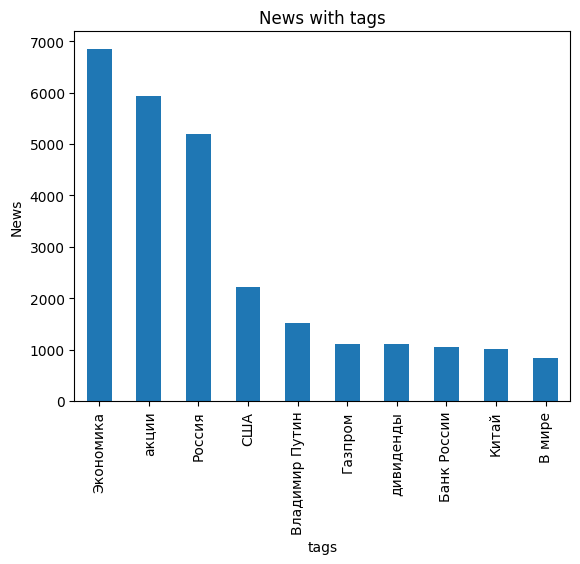

In [65]:
pd.Series(total_tags_key_words).value_counts().head(10).plot(kind='bar', title='News with tags', xlabel='tags', ylabel='News')

In [66]:
pd.Series(total_tags_key_words).value_counts().value_counts()

count
1       8766
2       1787
3        890
4        488
5        327
        ... 
175        1
169        1
166        1
164        1
6848       1
Name: count, Length: 207, dtype: int64

In [67]:
pd.Series(total_tags_key_words).value_counts()

Экономика                            6848
акции                                5940
Россия                               5193
США                                  2226
Владимир Путин                       1515
                                     ... 
Calpers                                 1
Uponor                                  1
Фабрика проектного финансирования       1
Эмираты                                 1
Бренды                                  1
Name: count, Length: 14162, dtype: int64

> __Выводы:__ 
> Большая часть ключевых слов встречается небольшое количество раз: от 1 до 3 раз встречаются 12000 тэгов и ключевых слов. 
>
> Скорее всего, редко встречаемые тэги не будут отражать никакие сущности, однако возможно среди них встречаются синонимы или части сущностей, которые отражены более встречающимися тэгами.
>
> На этапе обработки данных мы попробуем извлечь словарь сущностей.
>
> Наиболее встречающиеся ключевые слова тоже могут не являтся сущностями.

## Положим наш очищщенный датасет в новую таблицу в нашей базе данных

In [68]:
ts_total.index = pd.RangeIndex(len(ts_total.index))
ts_total = ts_total.drop('date', axis=1)
ts_total = ts_total.reset_index()

In [69]:
ts_total

index     website             section  \
0          0         РИА           Экономика   
1          1         РИА           Экономика   
2          2   Интерфакс           ЭКОНОМИКА   
3          3         РИА           Экономика   
4          4  Kommersant             Финансы   
...      ...         ...                 ...   
29894  29894         РИА           Экономика   
29895  29895         РИА           Экономика   
29896  29896         РИА           Экономика   
29897  29897         РИА  Краснодарский край   
29898  29898         РИА  Краснодарский край   

                                                     url  \
0          https://ria.ru/20230103/banki-1842907991.html   
1      https://ria.ru/20230103/avtomobili-1842908567....   
2                https://www.interfax.ru/business/879539   
3         https://ria.ru/20230103/nissan-1842909188.html   
4                  https://www.kommersant.ru/doc/5757823   
...                                                  ...   
29894  https://ria.ru/20231017/finansirovanie-1903460...   
29895     https://ria.ru/20231017/brendy-1903461295.html   
29896  https://ria.ru/20231017/deklaratsiya-190346195...   
29897     https://ria.ru/20231017/granty-1903465812.html   
29898  https://ria.ru/20231017/franshiza-1903467439.html   

                                                  header  \
0      Эксперт рассказал о развитии исламского банкин...   
1      Минпромторг спрогнозировал рост производства а...   
2      Рынок акций РФ открылся ростом индекса МосБирж...   
3            "АвтоВАЗу" передадут активы Nissan в России   
4      Индекс Мосбиржи растет на 0,5% на первой торго...   
...                                                  ...   
29894  Финансирование экспорта при санкциях обсудят н...   
29895  Стратегию развития российских брендов обсудят ...   
29896  Венгрия и Сербия в декларации назвали действия...   
29897  Кубань выделила 140 миллионов рублей на гранты...   
29898  Бизнесменов Кубани благодаря нацпроекту беспла...   

                                                    body  \
0        Порядка 10-15 филиалов исламского банкинга м...   
1        Минпромторг прогнозирует в наступившем году ...   
2        - Рынок акций РФ открылся во вторник ростом ...   
3        Подведомственное Минпромторгу ФГУП "НАМИ" пе...   
4      Индекс Московской биржи на открытии торгов рас...   
...                                                  ...   
29894    Участники сессии "Финансовый рынок для реаль...   
29895    Что Россия может предложить глобальному рынк...   
29896    Министр иностранных дел и внешнеэкономически...   
29897    Власти Краснодарского края выделили из краев...   
29898    Несколько десятков бизнесменов Краснодарског...   

                                                    tags  body_length  \
0             ['Экономика', 'Россия', 'Сбербанк России']         1759   
1      ['Экономика', 'Авто', 'Денис Мантуров', 'Росси...          808   
2                                   ['Московская биржа']         1249   
3      ['Экономика', 'Авто', 'Денис Мантуров', 'Минис...         1414   
4                                                    NaN          598   
...                                                  ...          ...   
29894  ['В России', 'Экономика', 'Россия', 'Форум "Сд...         2162   
29895  ['В России', 'Экономика', 'Россия', 'Бренды', ...         1551   
29896  ['Сербия', 'Венгрия', 'Болгария', 'Николай Ден...          908   
29897  ['Краснодарский край', 'Экономика', 'Краснодар...         1081   
29898  ['Краснодарский край', 'Экономика', 'Краснодар...         1062   

                  datetime  
0      2023-01-03 10:16:00  
1      2023-01-03 10:20:00  
2      2023-01-03 10:22:00  
3      2023-01-03 10:29:00  
4      2023-01-03 10:31:00  
...                    ...  
29894  2023-10-17 21:05:00  
29895  2023-10-17 21:10:00  
29896  2023-10-17 21:14:00  
29897  2023-10-17 21:45:00  
29898  2023-10-17 21:53:00  

[29899 rows x 9 columns]

In [70]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True
ts_total.to_sql('clean_data', con=conn, if_exists='replace', index=False) 
conn.close()

In [71]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

df = pd.read_sql_query('SELECT * FROM clean_data', conn)
conn.close()

In [72]:
df

index     website             section  \
0          0         РИА           Экономика   
1          1         РИА           Экономика   
2          2   Интерфакс           ЭКОНОМИКА   
3          3         РИА           Экономика   
4          4  Kommersant             Финансы   
...      ...         ...                 ...   
29894  29894         РИА           Экономика   
29895  29895         РИА           Экономика   
29896  29896         РИА           Экономика   
29897  29897         РИА  Краснодарский край   
29898  29898         РИА  Краснодарский край   

                                                     url  \
0          https://ria.ru/20230103/banki-1842907991.html   
1      https://ria.ru/20230103/avtomobili-1842908567....   
2                https://www.interfax.ru/business/879539   
3         https://ria.ru/20230103/nissan-1842909188.html   
4                  https://www.kommersant.ru/doc/5757823   
...                                                  ...   
29894  https://ria.ru/20231017/finansirovanie-1903460...   
29895     https://ria.ru/20231017/brendy-1903461295.html   
29896  https://ria.ru/20231017/deklaratsiya-190346195...   
29897     https://ria.ru/20231017/granty-1903465812.html   
29898  https://ria.ru/20231017/franshiza-1903467439.html   

                                                  header  \
0      Эксперт рассказал о развитии исламского банкин...   
1      Минпромторг спрогнозировал рост производства а...   
2      Рынок акций РФ открылся ростом индекса МосБирж...   
3            "АвтоВАЗу" передадут активы Nissan в России   
4      Индекс Мосбиржи растет на 0,5% на первой торго...   
...                                                  ...   
29894  Финансирование экспорта при санкциях обсудят н...   
29895  Стратегию развития российских брендов обсудят ...   
29896  Венгрия и Сербия в декларации назвали действия...   
29897  Кубань выделила 140 миллионов рублей на гранты...   
29898  Бизнесменов Кубани благодаря нацпроекту беспла...   

                                                    body  \
0        Порядка 10-15 филиалов исламского банкинга м...   
1        Минпромторг прогнозирует в наступившем году ...   
2        - Рынок акций РФ открылся во вторник ростом ...   
3        Подведомственное Минпромторгу ФГУП "НАМИ" пе...   
4      Индекс Московской биржи на открытии торгов рас...   
...                                                  ...   
29894    Участники сессии "Финансовый рынок для реаль...   
29895    Что Россия может предложить глобальному рынк...   
29896    Министр иностранных дел и внешнеэкономически...   
29897    Власти Краснодарского края выделили из краев...   
29898    Несколько десятков бизнесменов Краснодарског...   

                                                    tags  body_length  \
0             ['Экономика', 'Россия', 'Сбербанк России']         1759   
1      ['Экономика', 'Авто', 'Денис Мантуров', 'Росси...          808   
2                                   ['Московская биржа']         1249   
3      ['Экономика', 'Авто', 'Денис Мантуров', 'Минис...         1414   
4                                                   None          598   
...                                                  ...          ...   
29894  ['В России', 'Экономика', 'Россия', 'Форум "Сд...         2162   
29895  ['В России', 'Экономика', 'Россия', 'Бренды', ...         1551   
29896  ['Сербия', 'Венгрия', 'Болгария', 'Николай Ден...          908   
29897  ['Краснодарский край', 'Экономика', 'Краснодар...         1081   
29898  ['Краснодарский край', 'Экономика', 'Краснодар...         1062   

                 datetime  
0     2023-01-03 10:16:00  
1     2023-01-03 10:20:00  
2     2023-01-03 10:22:00  
3     2023-01-03 10:29:00  
4     2023-01-03 10:31:00  
...                   ...  
29894 2023-10-17 21:05:00  
29895 2023-10-17 21:10:00  
29896 2023-10-17 21:14:00  
29897 2023-10-17 21:45:00  
29898 2023-10-17 21:53:00  

[29899 rows x 9 columns]